In [1]:
# For Colab
!pip -q install geopandas 

In [2]:
%config InlineBackend.figure_formats = ['svg']
import os
import json
import numpy as np
import pandas as pd; pd.set_option('display.max_rows', 200)
import geopandas as gpd
import matplotlib.pyplot as plt
from collections import defaultdict
from state_data import load_state_data

In [3]:
use_gurobi = True
try:
    import gurobipy
except ImportError:
    print('Warning: Gurobi not installed. Using CVXPY.')
    use_gurobi = False

if use_gurobi:
    from gurobi_model import run_gurobi_model as run_model
else:
    from cvxpy_model import run_cvxpy_model as run_model

# About the hospital-university bed assignment model

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)]()

The COVID-19 crisis is expected to [cause a significant strain](https://covid19.healthdata.org/) on hospitals in the United States. Under normal circumstances, [about 70% of beds are in use at any given time in an urban hospital.](https://www.beckershospitalreview.com/patient-flow/capacity-dashboard-52-statistics-on-u-s-hospital-capacity.html) Hospitals will need to add auxiliary beds to handle the massive influx of COVID-19 patients expected in the coming months while continuing to offer care to non-COVID-19 patients. Additionally, many health care professionals may need to live away from their families during the peak of the COVID-19 crisis, as the disease is highly contagious. Tufts president Tony Monaco has suggested using the dormitory capacity at universities that have dedensified their campuses by sending most undergraduate students home to help fill this need. Some recovering COVID and non-COVID patients alike can be housed in dorms if they do not require specialized, intensive care; dormitory housing is also adequate for health care professionals.

This notebook seeks to verify the logistical thesis of President Monaco's proposal: **In Massachusetts, are there enough dormitory beds in close proximity to hospitals to significantly alleviate the burden on hospitals at the peak of the COVID crisis?** The raw bed counts of university dormitories far exceed those of hospitals in Massachusetts; while this is true throughout the country, Massachusetts is particularly notable as a national and global center of higher education. However, for Monaco's proposal to be feasible, we must also check that the spatiality of hospitals and universities is closely aligned enough that it is convenient to move patients and staff back and forth.

Our model uses an optimization algorithm to move beds from hospitals to universities such that the average distance between a bed's origin (a hospital) and its destination (a university) is minimized. We currently only consider recovering non-COVID patients and health care professionals; modeling for recovering COVID patients is forthcoming.

## Assumptions and choices
* Our model primarily considers acute-care hospitals—psychiatric hospitals are not currently included. Rehabilitation hospitals are included, but will likely be removed in the near future unless explicitly included on a case-by-case basis.

* It is unclear what percentage of beds each university may be able to offer to hospitals. At Tufts, approximately 90% of beds are currently open after dedensification. However, it is unrealistic to assume that every open bed can be used—for instance, efficiency may be reduced by the presumed need to keep patients, health care professionals, and remaining students in separate buildings. Furthermore, social distancing measures may prevent full utilization within a single dormitory. Outputs of our model at 30%, 40%, and 50% maximum bed utilization across all universities are similar, and our model can easily be refined to include actual available bed counts as they become available from participating universities.

* It is clearly inefficient to allocate just a few beds to a university when it is not absolutely necessary, so our model allocates beds such that every university is either entirely unused or is used with a minimum of 5% bed utilization.

* We currently filter out universities with fewer than 200 beds.

* To estimate the number of beds needed for health care professionals, we assume a 40-hour workweek and assume that each patient recieves 12 person-hours of care per day, such that 2.1 workers are devoted to every patient. Multiplying this factor by the number of available beds in each hospital (under the assumption of 100% bed utilization at every hospital during the peak of the COVID crisis). We then assume that 30% of health care professionals will decide to isolate from their families in a dormitory. This is close to the upper bound—Mike Apkon estimates that between 5% and 50% of professionals will actually decide to do so.

* We assume that only 50% of non-COVID patients can be moved from a hospital to a university.

## Other states
This notebook supports similar analysis for all 50 U.S. states (change the `state_code` parameter below). States other than Massachusetts rely on national-data from the Department of Homeland Security. We have not thoroughly reviewed the model's outputs for states other than Massachusetts, New York, and Michigan.

## The math
We model the university-hospital bed assignment problem as a discrete [optimal transport](https://en.wikipedia.org/wiki/Transportation_theory_(mathematics)) problem. This notebook interfaces with a simplified version of our model runnable using the open-source [CVXPY](http://cvxpy.org/) convex programming package and a refined version of our model that employs [Gurobi](https://www.gurobi.com/), a commercial solver (freely available for academic use). [See the MGGG website for a full writeup (pdf).](https://mggg.org/uploads/COVID-LP.pdf)

In [4]:
ed_inst_max_utilization_pct = 0.5
ed_inst_min_utilization_beds = 20
ed_inst_min_beds = 200

# Per Mike Apkon: each patient receives 12 person-hours of care per day (under normal conditions).
# Assuming a 40-hour workweek, this implies 1.5 staff members are fully allocated to each patient on each day.
# (Note: does this average include ICU patients? Presumably they get more care.)
# General consensus seems to be that care per patient will *decrease* as hospitals get overloaded with COVID cases,
# so consider staffing estimates to be an upper bound.
staff_hours_per_day = 8
staff_days_per_week = 5
patient_person_hours_per_day = 12
staff_per_patient = (patient_person_hours_per_day * 7) / (staff_hours_per_day * staff_days_per_week)

# What percentage of non-COVID patients can be moved into a dorm?
# (This parameter also encapsulates the fact that most patients probably need to present at the hospital
#  and *then* moved to the dorms.)
patient_bed_demand_pct = 0.5
# What percentage of staff will want to stay in a dorm rather than going home?
staff_bed_demand_pct = 0.3
# We assume that staff is assigned to 100% of hospital+ICU beds at the peak of the outbreak.
staff_utilized_pct = 1

# How much more expensive is it to move a patient vs. a staff member (per mile)?
relative_transport_cost = 1

# Normal hospital bed utilization is roughly 70%
normal_beds_utilized_pct = 0.7

In [5]:
state_code = 'NY'

In [6]:
results_path = os.path.join('results', state_code)
os.makedirs(results_path, exist_ok=True)

In [7]:
state = load_state_data(state_code=state_code,
                        min_dorm_beds=ed_inst_min_beds,
                        prefer_travel_time=True)

In [8]:
distances = state['distances']
ed_inst_gdf = state['ed_inst']
hospitals_gdf = state['hospitals']
outline_gdf = state['outline']

## Spatiality of hospitals and universities
In the plot below, <span style="color:blue">universities are blue circles,</span> <span style="color:red">acute care hospitals are red squares,</span> and <span style="color:green">non-acute care hospitals are green diamonds.</span> Hospitals and universities are sized by number of beds. In Massachusetts, there are clearly far more university beds than hospital beds, and their spatiality is favorable—in general, hospitals tend to be close to universities.

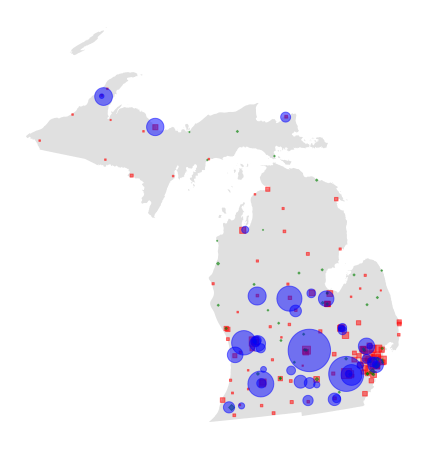

In [9]:
acute_care_gdf = hospitals_gdf[hospitals_gdf['ACUTE']]
non_acute_care_gdf = hospitals_gdf[~hospitals_gdf['ACUTE']]

fig, ax = plt.subplots(figsize=(16, 8))
base = outline_gdf.plot(ax=ax, color='#e0e0e0')
acute_care_gdf.plot(ax=base, marker='s', color='red', alpha=0.5,
                    markersize=0.1 * acute_care_gdf['BEDS'])
non_acute_care_gdf.plot(ax=base, marker='D', color='green', alpha=0.5,
                        markersize=0.1 * non_acute_care_gdf['BEDS'])
ed_inst_gdf.plot(ax=base, marker='o', color='blue', alpha=0.5,
                 markersize=0.1 * ed_inst_gdf['DORM_CAP'])
plt.axis('off')
plt.savefig(os.path.join(results_path, f'{state_code}_beds.png'),
            bbox_inches='tight', dpi=600)
plt.show()

In [10]:
n_hosp = len(hospitals_gdf)
n_ed = len(ed_inst_gdf)

In [11]:
dorm_bed_capacity = np.round(ed_inst_max_utilization_pct *
                             ed_inst_gdf['DORM_CAP'].to_numpy())
patient_bed_demand = np.round(normal_beds_utilized_pct *
                              patient_bed_demand_pct *
                              hospitals_gdf['BEDS'].to_numpy())
staff_bed_demand = np.round(staff_per_patient *
                            staff_bed_demand_pct *
                            staff_utilized_pct *
                            hospitals_gdf['BEDS'].to_numpy())

In [12]:
results = run_model(
    distances=distances,
    dorm_bed_capacity=dorm_bed_capacity,
    staff_bed_demand=staff_bed_demand,
    patient_bed_demand=patient_bed_demand,
    relative_transport_cost=relative_transport_cost,
    min_ed_inst_beds=ed_inst_min_utilization_beds,
    max_hosp_per_ed_inst=n_hosp
)

Using license file /Users/pjrule/gurobi.lic
Academic license - for non-commercial use only
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (mac64)
Optimize a model with 261 rows, 22302 columns and 29736 nonzeros
Model fingerprint: 0x8f008bd8
Model has 396 quadratic constraints
Variable types: 0 continuous, 22302 integer (7434 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [2e+00, 8e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
  QRHS range       [1e+00, 9e+03]
Presolve removed 42 rows and 0 columns
Presolve time: 0.09s
Presolved: 30351 rows, 66906 columns, 126378 nonzeros
Presolved model has 29736 SOS constraint(s)
Variable types: 0 continuous, 66906 integer (22302 binary)
Found heuristic solution: objective 2272108.2183

Root relaxation: objective 9.273135e+05, 3130 iterations, 0.13 seconds

    Nodes    |    Current N

In [13]:
staff_results = results['staff']
patient_results = results['patient']

In [14]:
def plot_assignments(results):
    fig, ax = plt.subplots(figsize=(16, 8))
    base = outline_gdf.plot(ax=ax, color='#e0e0e0')
    hospitals_gdf.plot(ax=base, marker='s', color='red', alpha=0.5,
                        markersize=0.1 * hospitals_gdf['BEDS'])
    ed_inst_gdf.plot(ax=base, marker='o', color='blue', alpha=0.5,
                     markersize=0.1 * ed_inst_gdf['DORM_CAP'])

    for hosp_idx in range(n_hosp):
        for ed_idx in range(n_ed):
            if results[hosp_idx, ed_idx] > 0:
                p_hosp = hospitals_gdf.iloc[hosp_idx].geometry
                p_ed = ed_inst_gdf.iloc[ed_idx].geometry
                ax.plot([p_hosp.x, p_ed.x], [p_hosp.y, p_ed.y],
                        color='black',
                        linewidth=0.01 * results[hosp_idx, ed_idx])
                
    plt.axis('off')

# Results
Our model's assignments are exported for use with [MGGG's Campus Coronavirus Response website](https://mggg.org/covid-flows/index.html).

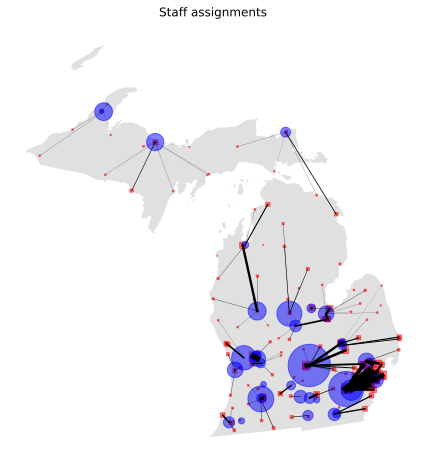

In [15]:
plot_assignments(staff_results)
plt.title('Staff assignments')
plt.savefig(os.path.join(results_path, f'{state_code}_staff_assignments.png'),
            bbox_inches='tight', dpi=600)
plt.show()

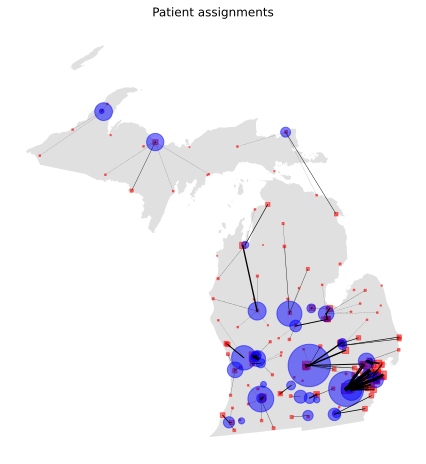

In [16]:
plot_assignments(patient_results)
plt.title('Patient assignments')
plt.savefig(os.path.join(results_path, f'{state_code}_patient_assignments.png'),
            bbox_inches='tight', dpi=600)
plt.show()

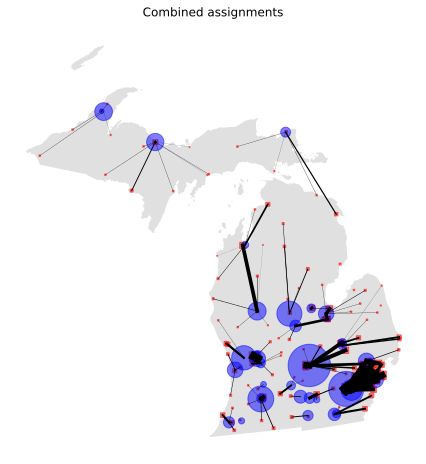

In [17]:
plot_assignments(staff_results + patient_results)
plt.title('Combined assignments')
plt.savefig(os.path.join(results_path, f'{state_code}_combined_assignments.png'),
            bbox_inches='tight', dpi=600)
plt.show()

In [18]:
def save_assignments(results, filename):
    assignments = []
    for hosp_idx, hosp_row in hospitals_gdf.iterrows():
        for ed_idx, ed_row in ed_inst_gdf.iterrows():
            if results[hosp_idx, ed_idx] > 0:
                assignments.append({
                    'college': ed_row['NAME'],
                    'hospital': hosp_row['NAME'],
                    'weight': int(results[hosp_idx, ed_idx])
                })
    with open(filename, 'w') as f:
        json.dump(assignments, f)

In [19]:
save_assignments(patient_results + staff_results,
                 os.path.join(results_path, f'{state_code}_combined_results.json'))

In [20]:
staff_by_inst = np.sum(staff_results, axis=0)
patients_by_inst = np.sum(patient_results, axis=0)
ed_assignment_df = ed_inst_gdf[['NAME', 'CITY', 'DORM_CAP']].copy()
ed_assignment_df = ed_assignment_df.rename(columns={
    'NAME': 'Name',
    'CITY': 'City',
    'DORM_CAP': 'Beds'
})
ed_assignment_df['Hospital staff'] = staff_by_inst.astype(int)
ed_assignment_df['Patients'] = patients_by_inst.astype(int)
utilization_rounded = (1000 * (ed_assignment_df['Hospital staff'] + ed_assignment_df['Patients']) / ed_assignment_df['Beds'])
ed_assignment_df['Utilization (%)'] = utilization_rounded
ed_assignment_df = ed_assignment_df.dropna()
ed_assignment_df['Utilization (%)'] = ed_assignment_df['Utilization (%)'].astype(int) / 10.0 
ed_assignment_df.to_csv(os.path.join(results_path, f'{state_code}_ed_inst_assignments.csv'),
                        index=False)